In [1]:
# Import required libs
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import os
import random

In [2]:
## Creating helper functions
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2025-01-21 09:08:54--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2025-01-21 09:08:54 (16.7 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [3]:
# Import the functions needed
from helper_functions import create_tensorboard_callback, plot_loss_curves, pred_and_plot, unzip_data, walk_through_dir, compare_historys, confusion_matrix


In [4]:
!unzip '/content/augmented_shape_data.zip'
!unzip '/content/generated_data_with_summation.zip'

Streaming output truncated to the last 5000 lines.
  inflating: augmented_shape_data/0/Zero_96.png  
  inflating: augmented_shape_data/0/Zero_97.png  
  inflating: augmented_shape_data/0/Zero_98.png  
  inflating: augmented_shape_data/0/Zero_99.png  
   creating: augmented_shape_data/1/
  inflating: augmented_shape_data/1/One_1.png  
  inflating: augmented_shape_data/1/One_10.png  
  inflating: augmented_shape_data/1/One_100.png  
  inflating: augmented_shape_data/1/One_101.png  
  inflating: augmented_shape_data/1/One_102.png  
  inflating: augmented_shape_data/1/One_103.png  
  inflating: augmented_shape_data/1/One_104.png  
  inflating: augmented_shape_data/1/One_105.png  
  inflating: augmented_shape_data/1/One_106.png  
  inflating: augmented_shape_data/1/One_107.png  
  inflating: augmented_shape_data/1/One_108.png  
  inflating: augmented_shape_data/1/One_109.png  
  inflating: augmented_shape_data/1/One_11.png  
  inflating: augmented_shape_data/1/One_110.png  
  inflating: aug

In [5]:
# walkthrough the data
walk_through_dir("/content/augmented_shape_data")

There are 10 directories and 0 images in '/content/augmented_shape_data'.
There are 0 directories and 500 images in '/content/augmented_shape_data/8'.
There are 0 directories and 500 images in '/content/augmented_shape_data/5'.
There are 0 directories and 500 images in '/content/augmented_shape_data/6'.
There are 0 directories and 500 images in '/content/augmented_shape_data/4'.
There are 0 directories and 500 images in '/content/augmented_shape_data/0'.
There are 0 directories and 500 images in '/content/augmented_shape_data/1'.
There are 0 directories and 500 images in '/content/augmented_shape_data/2'.
There are 0 directories and 500 images in '/content/augmented_shape_data/3'.
There are 0 directories and 500 images in '/content/augmented_shape_data/7'.
There are 0 directories and 500 images in '/content/augmented_shape_data/9'.


In [6]:
def show_random_image(dir):
  """Displays a random image from the given directory."""
  # Get a random image path
  target_dir = "/content/dataset/"

  # Store the class names
  class_names = []
  for subdir in os.listdir(train_dir):
    class_names.append(subdir)
  #print(class_names)

  target_class = random.choice(class_names)
  path = target_dir + "/" + dir + "/" +target_class
  image_path = random.choice(os.listdir(path))
  print(image_path)

  # Read the image
  import cv2
  image = cv2.imread(os.path.join(path, image_path))

  # Display the image
  plt.imshow(image)
  plt.title(target_class)
  plt.axis(False)
  plt.show()

In [8]:
pip install split-folders

In [9]:
import splitfolders

# Input folder containing class subfolders
input_folder = "/content/augmented_shape_data"

# Output folder for train-test splits
output_folder = "/content/dataset/"

# Perform the split (80% train, 20% test)
splitfolders.ratio(
    input_folder,
    output=output_folder,
    seed=42,
    ratio=(0.8, 0.2), # (train, test) split
    group_prefix=None # Ensures grouping of images in class folders
)

Copying files: 5000 files [00:00, 6814.95 files/s]


In [10]:
train_dir = "/content/dataset/train"
test_dir = "/content/dataset/val"

Eight_265.png


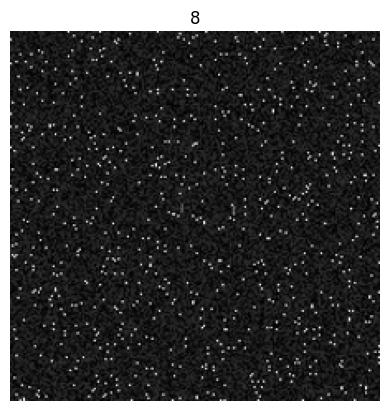

In [11]:
show_random_image("train")

In [12]:
## Setup data inputs
IMG_SIZE = (224, 224)

# Data loader
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                image_size = IMG_SIZE,
                                                                                label_mode = "categorical")

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                image_size = IMG_SIZE,
                                                                label_mode = "categorical",
                                                                shuffle = False)

Found 4000 files belonging to 10 classes.
Found 1000 files belonging to 10 classes.


In [13]:

# Create checkpoint callback to save model for later use
checkpoint_path = "model_checkpoint/checkpoint.weights.h5"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_best_only = True,
                                                         monitor = "val_accuracy",
                                                         save_weights_only = True)

In [14]:

# Create the augmentations
data_augmentation = Sequential([
    #layers.RandomFlip("horizontal"),
    layers.RandomZoom(0.2),
    layers.RandomRotation(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2)
    #layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
])


In [26]:
# Setup the base model
base_model = tf.keras.applications.VGG16(include_top = False)
base_model.trainable = False

# Set up the model architecture with trainable top layer
inputs = layers.Input(shape = (224, 224, 3), name = "input_layer")
x = data_augmentation(
    inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D(name = "global_average_pooling_2d")(x)
outputs = layers.Dense(10, activation="softmax", name = "output_layer")(x)
model_1 = keras.Model(inputs, outputs)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [28]:
# Get a summary of our model
model_1.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg16 (Functional)                   │ (None, None, None, 512)     │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling_2d            │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output_layer (Dense)                 │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 5,130 (20.04 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Compile the model
model_1.compile(loss = "categorical_crossentropy",
                optimizer = tf.keras.optimizers.Adam(),
                metrics = ['accuracy'])

# fit the model
history_all_classes_10_percent = model_1.fit(train_data_all_10_percent,
                                             validation_data = test_data,
                                             epochs = 20,
                                             callbacks = [checkpoint_callback])

Epoch 1/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 441s 4s/step - accuracy: 0.2622 - loss: 2.7053 - val_accuracy: 0.5700 - val_loss: 1.4900
Epoch 2/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 369s 3s/step - accuracy: 0.6636 - loss: 1.0295 - val_accuracy: 0.6630 - val_loss: 1.1088
Epoch 3/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 322s 2s/step - accuracy: 0.7439 - loss: 0.7907 - val_accuracy: 0.7020 - val_loss: 0.9639
Epoch 4/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7677 - loss: 0.7100 - val_accuracy: 0.7290 - val_loss: 0.8721
Epoch 5/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 294s 2s/step - accuracy: 0.7735 - loss: 0.6561 - val_accuracy: 0.7280 - val_loss: 0.7945
Epoch 6/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 250s 2s/step - accuracy: 0.7998 - loss: 0.6068 - val_accuracy: 0.7460 - val_loss: 0.7705
Epoch 7/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.8002 - loss: 0.5888 - val_accuracy: 0.7480 - val_loss: 0.7801
Epoch 8/20
125/125 ━━━━━━━━━━━━━━━━━━━━ 254s 2s/step - accuracy: 0.8050 - loss: 0.5666 - val_accu

In [22]:
# Evaluate model
results_feature_extraction_model = model_1.evaluate(test_data)
results_feature_extraction_model

32/32 ━━━━━━━━━━━━━━━━━━━━ 17s 527ms/step - accuracy: 0.7566 - loss: 0.6676


[0.5925176739692688, 0.7879999876022339]

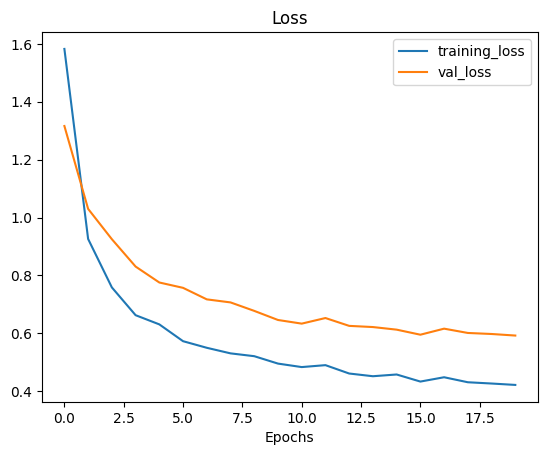

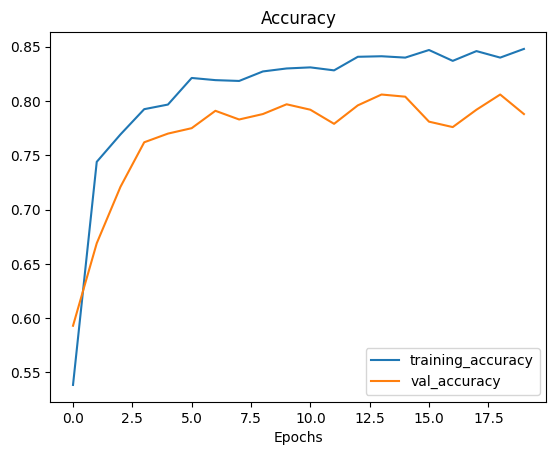

In [23]:
plot_loss_curves(history_all_classes_10_percent)

In [24]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze all layers except last 5 layers
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [25]:
# Recompile model
model_1.compile(loss = "categorical_crossentropy",
            optimizer = tf.keras.optimizers.Adam(0.0001),
            metrics = ['accuracy'])

# Fine tune for 5 more epochs
fine_tune_epochs = 40

# Fit the model
history_all_classes_10_percent_fine_tune = model_1.fit(train_data_all_10_percent,
                                                       validation_data = test_data,
                                                       #validation_steps = int(0.15 * len(test_data)),
                                                       epochs = fine_tune_epochs,
                                                       initial_epoch = history_all_classes_10_percent.epoch[-1])


Epoch 20/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 174s 1s/step - accuracy: 0.8493 - loss: 0.4285 - val_accuracy: 0.8110 - val_loss: 0.5765
Epoch 21/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 153s 859ms/step - accuracy: 0.8418 - loss: 0.4199 - val_accuracy: 0.8130 - val_loss: 0.5874
Epoch 22/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 106s 846ms/step - accuracy: 0.8504 - loss: 0.4071 - val_accuracy: 0.8080 - val_loss: 0.5564
Epoch 23/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 102s 818ms/step - accuracy: 0.8673 - loss: 0.3831 - val_accuracy: 0.7890 - val_loss: 0.5819
Epoch 24/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 774ms/step - accuracy: 0.8649 - loss: 0.3750 - val_accuracy: 0.7900 - val_loss: 0.5452
Epoch 25/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 774ms/step - accuracy: 0.8605 - loss: 0.3681 - val_accuracy: 0.7920 - val_loss: 0.5388
Epoch 26/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 97s 778ms/step - accuracy: 0.8570 - loss: 0.3901 - val_accuracy: 0.8040 - val_loss: 0.5462
Epoch 27/40
125/125 ━━━━━━━━━━━━━━━━━━━━ 93s 749ms/step - accuracy: 0.8526 

In [21]:
# Evaluate model
results_feature_extraction_model = model_1.evaluate(test_data)
results_feature_extraction_model

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 468ms/step - accuracy: 0.7255 - loss: 0.7760


[0.8522684574127197, 0.7099999785423279]

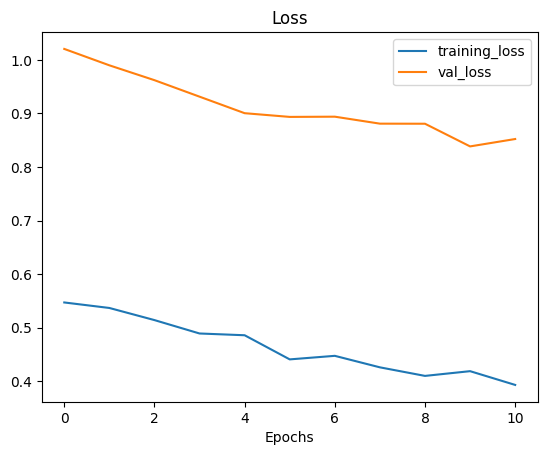

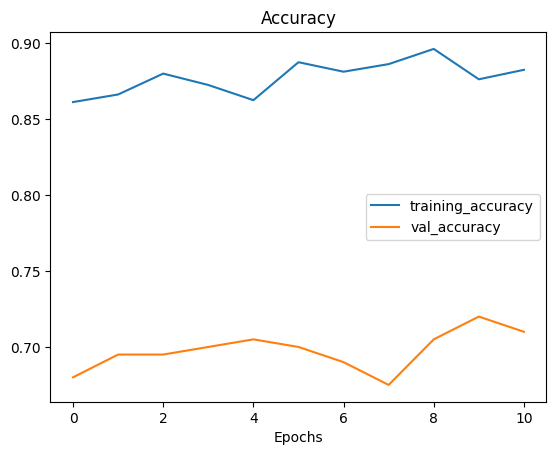

In [22]:
# Plot the curves
plot_loss_curves(history_all_classes_10_percent_fine_tune)

In [23]:
len(history_all_classes_10_percent_fine_tune.epoch)

11

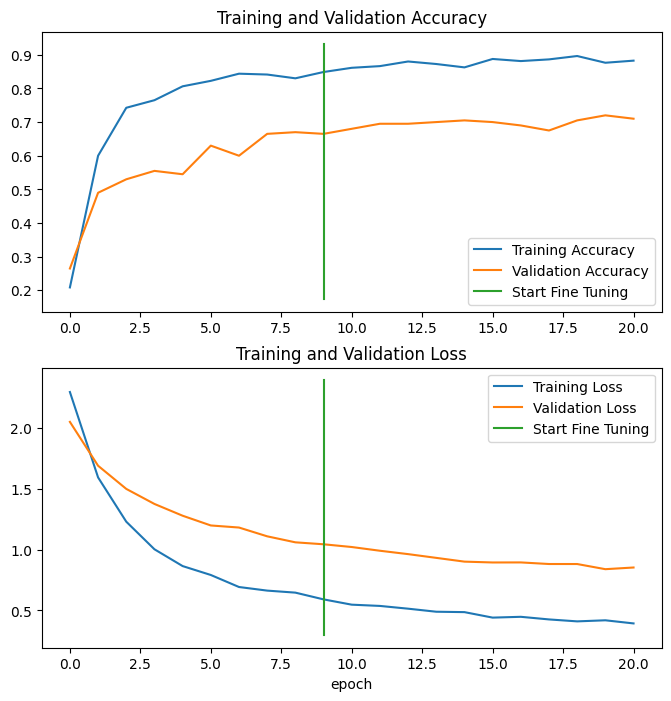

In [24]:
# Compare
compare_historys(history_all_classes_10_percent, history_all_classes_10_percent_fine_tune,initial_epochs=20)

In [ ]:

# save our fine tuned model
model_1.save("/content/saved_big_dog_model.keras")